In [1]:
# 新聞分類實作
# 使用路透社資料，成功訓練出可以把新聞分為 0~45 這 46 個類別的 model 就是本次實作目標。

In [2]:
# 一樣，從載入資料這一步開始
from keras.datasets import reuters

# 限制只取出句中字詞在字典集 0~9999 中的句子
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000) 

# 這邊先註明一下 : labels 的分類為 0 ~ 45，共 46 類新聞。

In [3]:
# 先來看看資料吧

print("train_data 長度: ", len(train_data))
print("test_data 長度: ", len(test_data))

print("第一筆資料: ", train_data[0])

train_data 長度:  8982
test_data 長度:  2246
第一筆資料:  [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [4]:
# 我們嘗試看看把 encoder 過的資料 decode 一下，看看原文。

word_index = reuters.get_word_index()

# 跟 IMDB 一樣，拿到的 word_index 要先反轉一下

reversed_word_index = dict([(val, key) for (key, val) in word_index.items()])

# for i in range(10):
#     print(reversed_word_index.items()[i])

for index, (k, v) in enumerate(reversed_word_index.items()):
    print(k, v)
    if index == 10:  # 印 10 筆來看看就好
        break

10996 mdbl
16260 fawc
12089 degussa
8803 woods
13796 hanging
20672 localized
20673 sation
20675 chanthaburi
10997 refunding
8804 hermann
20676 passsengers


In [5]:
tar = train_data[0]
decoded_sentence = ' '.join([reversed_word_index.get(i-3, '') for i in tar])
print("解碼後的資料: ", decoded_sentence)

解碼後的資料:     said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [6]:
# 好了，看完資料之後，我們接下來要做的就是把輸入資料向量化處理，這在上一節 IMDB 中已經提到過了，這邊不再贅述

import numpy as np

# seq 向量化處理
def vectorize_seq(seqs, dimension=10000):
    result = np.zeros((len(seqs), dimension))  # 建立一個空的張量，用來放置所有資料
    for index, seq in enumerate(seqs):
        result[index, seq] = 1
    return result

x_train = vectorize_seq(train_data)  # 訓練資料像量化
x_test = vectorize_seq(test_data)  # 測試資料像量化

x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [13]:
# 處理標籤資料
# 標籤資料是 0~45 的數字，我們要做的就是以 one-hot-encoding 的方式去轉化這些資料
# 以下提供一個手刻 one_hot func 以及一個 keras 官方提供的 one_hot func

def to_one_hot(labels, dimension=46):
    result = np.zeros((len(labels), dimension))
    
    for index, label in enumerate(labels):
        result[index, label] = 1.
        return result
    
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

print("手刻 one hot:\n", one_hot_test_labels)

手刻 one hot: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print("keras 內建 one hot:\n", one_hot_test_labels)

keras 內建 one hot:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
# 建構神經網路
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, ))) # 輸入為一個 Dimension，輸出層 64 神經元。
model.add(layers.Dense(64, activation='relu')) # 非線性轉換。
model.add(layers.Dense(46, activation='softmax')) # 輸出層使用 softmax 非線性層。取加權，46 維向量輸出。

In [19]:
# 接下來就是編譯了，這邊使用 categorical_crossentropy 當作損失函數，他可以測出兩個機率分布之間的差距。
# 換句話說就是神經網路輸出機率分布與 label 之間真實分布差距，透過縮小兩者差距來訓練 network。

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# 切割驗證 (val) 資料

x_val = x_train[:1000] # 開頭 1000 筆
x_train = x_train[1000:] # x_train 更新為 1000 筆往後的資料

y_val = one_hot_train_labels[:1000]
y_train = one_hot_train_labels[1000:]

In [21]:
# 開始訓練

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 58ms/step - loss: 2.5701 - accuracy: 0.5123 - val_loss: 1.7210 - val_accuracy: 0.6500
Epoch 2/20
16/16 [==============================] - 1s 36ms/step - loss: 1.3897 - accuracy: 0.7238 - val_loss: 1.2883 - val_accuracy: 0.7090
Epoch 3/20
16/16 [==============================] - 1s 37ms/step - loss: 1.0102 - accuracy: 0.7930 - val_loss: 1.1077 - val_accuracy: 0.7570
Epoch 4/20
16/16 [==============================] - 1s 36ms/step - loss: 0.7898 - accuracy: 0.8344 - val_loss: 1.0242 - val_accuracy: 0.7900
Epoch 5/20
16/16 [==============================] - 1s 37ms/step - loss: 0.6295 - accuracy: 0.8705 - val_loss: 0.9603 - val_accuracy: 0.8060
Epoch 6/20
16/16 [==============================] - 1s 37ms/step - loss: 0.5016 - accuracy: 0.8970 - val_loss: 0.9286 - val_accuracy: 0.8110
Epoch 7/20
16/16 [==============================] - 1s 37ms/step - loss: 0.4072 - accuracy: 0.9188 - val_loss: 0.9017 - val_accuracy: 0.8140
Epoch 8/20
16

In [22]:
# 訓練完成，一樣要畫圖來看看訓練的 history



print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


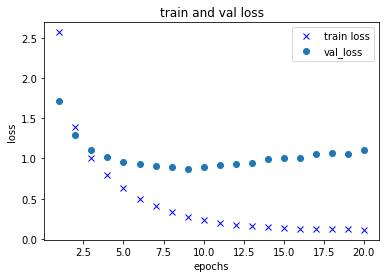

In [26]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)  # 1~20

plt.plot(epochs, loss, 'bx', label="train loss")
plt.plot(epochs, val_loss, 'o', label="val_loss")
plt.title("train and val loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# 以下是 loss 的表現，看起來再 5 輪之後 val loss 實際表現就穩定了

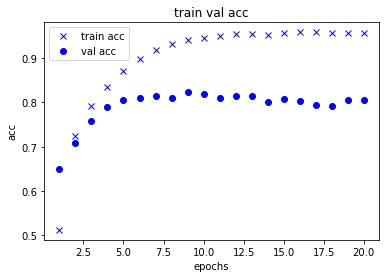

In [27]:
# 看一下 acc 表現

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.clf()

plt.plot(epochs, acc, "bx", label="train acc")
plt.plot(epochs, val_acc, "bo", label="val acc")
plt.title("train val acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

# 從下圖可以看出，基本上 val acc 也一樣，5 epochs 往後就幾乎穩定了

In [29]:
# 這個模型如果想要從 epoch 上調整的話就是把 epochs 設定在 7~9 之間，防止過度適配
# 最後對 test 資料實際使用看看

predictions = model.predict(x_test)
    
print(predictions)

[[1.05969968e-06 7.68324298e-06 1.48998382e-07 ... 5.34634772e-08
  3.55234286e-09 6.88081343e-08]
 [3.45220417e-03 3.14730220e-03 6.80857539e-08 ... 2.78334400e-09
  9.04383290e-10 9.38232547e-11]
 [2.62006633e-02 8.76786828e-01 2.96169765e-05 ... 3.76522894e-06
  4.95315987e-07 7.55239307e-05]
 ...
 [1.74060588e-07 1.08657077e-05 3.00706006e-06 ... 2.64407731e-07
  1.18669924e-07 2.31628383e-06]
 [4.85482952e-03 1.22045875e-01 9.07527574e-04 ... 1.67465652e-04
  6.47490788e-06 9.46410280e-03]
 [1.37268245e-04 4.41270441e-01 4.68163460e-04 ... 2.31223694e-05
  2.03153803e-07 1.43346711e-04]]


In [35]:
# 看看第一筆資料是哪一類

print("預測為: ", np.argmax(predictions[0]))
print("實際為: ", test_labels[0])

預測為:  3
實際為:  3


In [36]:
# 如果不使用 one_hot_encoding 作為 labels 的編碼也可以
# 還有一種方法是直接把分類資料(整數)當作實際值放入

y_train = np.array(train_labels)
y_test = np.array(test_labels)


In [37]:
# 如果 labels 變成實際整數，例如 24 或 46 之類的，我們要換損失函數。使用 'sparse_categorical_crossentropy'
# 與先前針對 one_hot_encoding 輸出的損失函數 'categorical_crossentropy' 不同，比對如下 : 

# categorical_crossentropy :

# [[1, 0, 0]
# [0, 1, 0]
# [0, 0, 1]]

# sparse_categorical_crossentropy

# 0
# 1
# 2